In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools
import warnings

import os

import numpy as np
import scipy as sp
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import FancyArrow
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
#from matplotlib.backends.backend_pdf import PdfPages

from src import depth
from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points
from src.transpositions import Transposition

from tqdm.notebook import tqdm

import imageio as io
from PIL import Image

# Defining Transposition Functions

## Catch the Difference betweeen Depth Posets

In [3]:
def depth_posets_are_different(dp0: DepthPoset, dp1: DepthPoset) -> bool:
    # 
    nodes0 = set([node.source for node in dp0.nodes])
    nodes1 = set([node.source for node in dp1.nodes])
    if nodes0 != nodes1:
        return True
    edges0 = set([(node0.source, node1.source) for node0, node1 in dp0.edges])
    edges1 = set([(node0.source, node1.source) for node0, node1 in dp1.edges])
    if edges0 != edges1:
        return True
    return False

## Generate a Simplex Tree from given order

In [4]:
def get_stree_from_order(order, values=None):
    # 
    if values is None:
        values = np.arange(len(order))
    stree = gh.SimplexTree()
    for simplex, value in zip(order, values):
        stree.insert(simplex, value)
    return stree

# Full Random Model

In this model we define the simplicial complex by the Delauney triangulation of $n$ points uniformly distributed in $[0, 1]^d$ ($d = 2$).

After this we define a random filtration for each simplex:
$$
    f(s) \sim U[\dim{s}, \dim{s} + 1]
$$

## Generate a Delauney Complex and 2 Filtrations on this

/tmp/ipykernel_100289/933326602.py:23: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  line, = axs[1].plot([0, 1], [filtration0[i], filtration1[i]], color=colors[i], label=simplices[i])
/tmp/ipykernel_100289/933326602.py:23: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  line, = axs[1].plot([0, 1], [filtration0[i], filtration1[i]], color=colors[i], label=simplices[i])


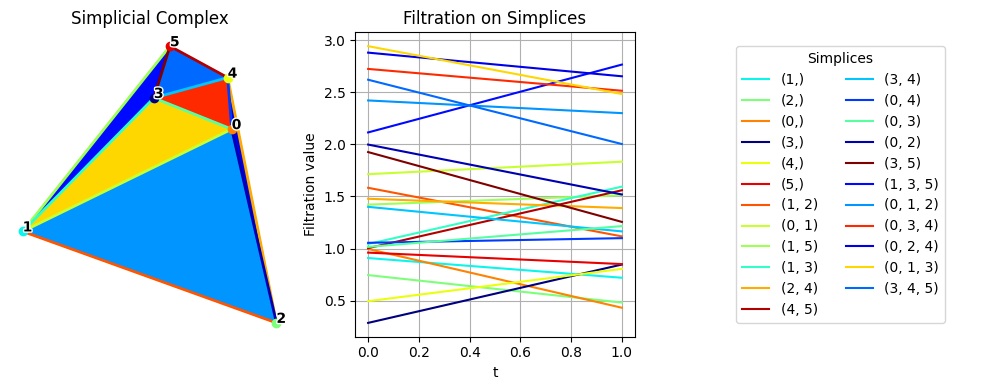

In [5]:
n = 6
complex_dimension = 2
points = np.random.random([n, complex_dimension])

simplices = np.array([tuple(s) for s, _ in gh.AlphaComplex(points).create_simplex_tree().get_simplices()], dtype=object)
simplices = simplices[np.argsort([len(s) for s in simplices])]
dims = np.vectorize(len)(simplices) - 1

filtration0 = np.random.random(len(simplices)) + dims
filtration1 = np.random.random(len(simplices)) + dims

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

colors = np.linspace(0, 1, len(simplices))
colors = np.random.choice(colors, len(colors), replace=False)
colors = plt.get_cmap('jet')(colors)
lines = []
labels = []

for i in range(len(simplices)):
    plot_simplex(list(simplices[i]), points, color=colors[i], ax=axs[0])
    
    line, = axs[1].plot([0, 1], [filtration0[i], filtration1[i]], color=colors[i], label=simplices[i])
    lines.append(line)
    labels.append(str(simplices[i]))

axs[0].set_title('Simplicial Complex')
axs[0].axis('off')
enumerate_points(points, ax=axs[0], weight='semibold', forewidth=2)

axs[1].set_title('Filtration on Simplices')
axs[1].set_xlabel('t')
axs[1].set_ylabel('Filtration value')
axs[1].grid(True)

axs[2].axis('off')
axs[2].legend(lines, labels, loc='center', title="Simplices", ncol=np.ceil(len(simplices)/18))

plt.tight_layout()
plt.show()

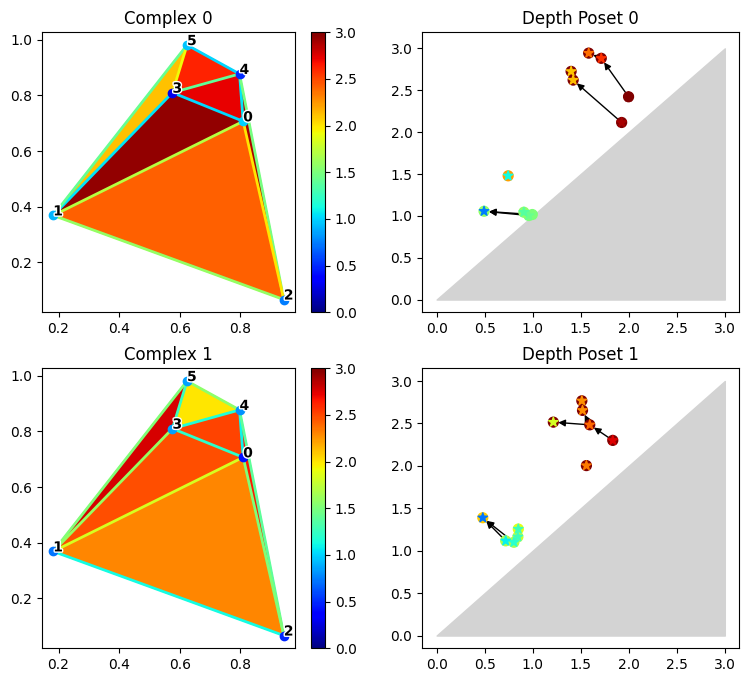

In [6]:
stree0 = gh.SimplexTree()
for simplex, value in zip(simplices, filtration0):
    stree0.insert(simplex, value)
dp0 = DepthPoset.from_simplex_tree(stree0)

stree1 = gh.SimplexTree()
for simplex, value in zip(simplices, filtration1):
    stree1.insert(simplex, value)
dp1 = DepthPoset.from_simplex_tree(stree1)

cmap = plt.get_cmap('jet')
fig, axs = plt.subplots(2, 2, figsize=(9, 8))
for i, (streei, dpi) in enumerate(zip([stree0, stree1], [dp0, dp1])):
    axs[i, 0].set_title(f'Complex {i}')
    sm = plot_filtred_complex2d(streei, points, ax=axs[i, 0], cmap=cmap, vmin=0, vmax=complex_dimension+1)
    plt.colorbar(sm, ax=axs[i, 0])
    enumerate_points(points, ax=axs[i, 0], weight='semibold', forewidth=2)
    
    birth_colors = [cmap(streei.filtration(node.source[0])/complex_dimension) for node in dpi.nodes]
    death_colors = [cmap(streei.filtration(node.source[1])/complex_dimension) for node in dpi.nodes]

    axs[i, 1].set_title(f'Depth Poset {i}')
    nx.draw_networkx_edges(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[i, 1], 
                           node_size=50, hide_ticks=False)
    nx.draw_networkx_nodes(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[i, 1], 
                           node_size=50, node_shape='o', node_color=death_colors, hide_ticks=False)
    nx.draw_networkx_nodes(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[i, 1], 
                           node_size=50, node_shape='*', node_color=birth_colors, hide_ticks=False)
    
    axs[i, 1].fill_between([0, complex_dimension + 1], [0, 0], [0, complex_dimension + 1], color='lightgrey')

In [7]:
depth_posets_are_different(dp0, dp1), dp0 != dp1

(True, True)

In [8]:
dp0.nodes[0], dp1.nodes[0]

(ShallowPair([1.9982, 2.4219], source=((0, 2), (0, 1, 2)), dim=1),
 ShallowPair([1.8339, 2.3001], source=((0, 1), (0, 1, 2)), dim=1))

## Define the Transposition Moments

In [9]:
def get_cross_parameters(y0, y1, t0=0, t1=1, filter_outside=True):
    """
    Returns the matrix of cross parameters between two arrays.

    Parameters:
        y0, y1: two arrays of the same length
        t0, t1: the time points for the arrays
        filter_outside: if True, filter out the values outside the range [t0, t1]

    Returns:
        cross_parameters: the matrix of cross parameters
    """
    y0 = np.asarray(y0)
    y1 = np.asarray(y1)
    if y0.shape != y1.shape:
        raise ValueError("Arrays must have the same length.")
    if y0.ndim != 1:
        raise ValueError("Arrays must be 1D.")
    
    yi0 = y0.reshape(-1, 1)
    yi1 = y1.reshape(-1, 1)
    yj0 = y0.reshape(1, -1)
    yj1 = y1.reshape(1, -1)

    cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


    if filter_outside:
        cross_parameters[cross_parameters < min(t0, t1)] = np.nan
        cross_parameters[cross_parameters > max(t0, t1)] = np.nan
    return cross_parameters

In [10]:
cross_parameters = [get_cross_parameters(filtration0[dims == i], filtration1[dims == i]) for i in range(complex_dimension + 1)]

eps = 0.8*min([min(np.unique(np.triu(i))[1:-1] - np.unique(np.triu(i))[:-2]) for i in cross_parameters])


/tmp/ipykernel_100289/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


In [11]:


df_transpositions = []
for dim, cross_parameters_dim in enumerate(cross_parameters):
    for i0, i1 in np.argwhere(~np.isnan(cross_parameters_dim) & np.triu(np.ones(cross_parameters_dim.shape, dtype=bool))):
        # define time and filtration value
        time = cross_parameters_dim[i0, i1]
        filtration_value = filtration0[dims == dim][i0]*(1 - time) + filtration1[dims == dim][i0]*time

        # define simplices
        simplex0 = simplices[dims == dim][i0]
        simplex1 = simplices[dims == dim][i1]

        # define the complex and the depth poset before the transposition
        time_before = time - eps
        filtration_before = filtration0*(1 - time_before) + filtration1*time_before
        stree_before = gh.SimplexTree()
        for simplex, value in zip(simplices, filtration_before):
            stree_before.insert(simplex, value)
        dp_before = DepthPoset.from_simplex_tree(stree_before)

        # define the complex and the depth poset after the transposition
        time_after = time + eps
        filtration_after = filtration0*(1 - time_after) + filtration1*time_after
        stree_after = gh.SimplexTree()
        for simplex, value in zip(simplices, filtration_after):
            stree_after.insert(simplex, value)
        dp_after = DepthPoset.from_simplex_tree(stree_after)

        # initialize transposition
        df_transpositions.append(
            {   
                'time': time,
                'value': filtration_value, 
                'stree before': stree_before.copy(), 
                'stree after': stree_after.copy(), 
                'transposition object': Transposition.from_simplex_tree(stree_before, simplex0, simplex1), 
                'changing': dp_before != dp_after, 
            }
        )

for i in range(len(df_transpositions)):
    df_transpositions[i].update(df_transpositions[i]['transposition object'].to_dict())
    if df_transpositions[i]['type'] in ['birth-birth', 'death-death', 'birth-death']:
        df_transpositions[i].update({'delta': df_transpositions[i]['transposition object'].get_classifying_matrix(reduce_matrix=True)})



df_transpositions = pd.DataFrame(df_transpositions)
df_transpositions = df_transpositions.sort_values('time')

df_transpositions.loc[(df_transpositions['switch'] == 'switch forward') | (df_transpositions['switch'] == 'switch backward'), 'switch'] = 'switch'

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
df_transpositions.shape = (44, 14)


,time,value,stree before,stree after,transposition object,changing,index 0,index 1,cell 0,cell 1,dim,type,switch,delta
24,0.022772,1.055621,<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(1, 3), (0, 4)>",False,8,9,"(1, 3)","(0, 4)",1,death-death,no switch,"((0, 1), (1, 0))"
31,0.033548,1.022146,<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(4, 5), (0, 3)>",False,6,7,"(4, 5)","(0, 3)",1,death-death,no switch,"((1, 0), (0, 1))"
8,0.077752,0.951928,<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(5,), (0,)>",False,4,5,"(5,)","(0,)",0,birth-birth,no switch,"((0, 1), (1, 0))"
30,0.100007,1.059089,<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(4, 5), (0, 4)>",True,7,8,"(4, 5)","(0, 4)",1,death-death,no switch,"((1, 1), (1, 0))"
0,0.232422,0.864583,<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(1,), (0,)>",False,3,4,"(1,)","(0,)",0,birth-birth,no switch,"((0, 1), (1, 0))"


In [12]:
df_transpositions[['changing', 'type', 'switch']].value_counts(dropna=False).reset_index().pivot_table(index=['type', 'switch'], columns='changing', values='count').fillna(0).astype(int)

changing                  False  True 
type           switch                 
birth-birth    no switch     11      1
               switch         0      5
birth-death    no switch      4      0
               switch         0      4
birth-unpaired undefined      0      2
death-death    no switch      8      4
               switch         0      5

In [13]:
df_transpositions[['changing', 'type', 'switch', 'delta']].value_counts(dropna=False).reset_index().pivot_table(index=['type', 'switch', 'delta'], columns='changing', values='count').fillna(0).astype(int)

changing                                                                  False  \
type        switch    delta                                                       
birth-birth no switch ((0, 1), (1, 0))                                        5   
                      ((0, 1), (1, 1))                                        0   
                      ((1, 0), (0, 1))                                        6   
            switch    ((1, 0), (1, 1))                                        0   
                      ((1, 1), (1, 0))                                        0   
birth-death no switch ((0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, ...      2   
                      ((0, 1, 0, 0), (0, 0, 0, 0), (0, 0, 0, 1), (0, ...      2   
            switch    ((0, 1, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0, ...      0   
death-death no switch ((0, 1), (1, 0))                                        4   
                      ((1, 0), (0, 1))                                        4   
                      ((1, 1), (0, 1))                                        0   
                      ((1, 1), (1, 0))                                        0   
            switch    ((0, 1), (1, 1))                                        0   
                      ((1, 0), (1, 1))                                        0   

changing                                                                  True   
type        switch    delta                                                      
birth-birth no switch ((0, 1), (1, 0))                                        0  
                      ((0, 1), (1, 1))                                        1  
                      ((1, 0), (0, 1))                                        0  
            switch    ((1, 0), (1, 1))                                        2  
                      ((1, 1), (1, 0))                                        3  
birth-death no switch ((0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, ...      0  
                      ((0, 1, 0, 0), (0, 0, 0, 0), (0, 0, 0, 1), (0, ...      0  
            switch    ((0, 1, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0, ...      4  
death-death no switch ((0, 1), (1, 0))                                        0  
                      ((1, 0), (0, 1))                                        0  
                      ((1, 1), (0, 1))                                        1  
                      ((1, 1), (1, 0))                                        3  
            switch    ((0, 1), (1, 1))                                        2  
                      ((1, 0), (1, 1))                                        3

## Plot the switch and not swithc transpositions

In [14]:
def get_plot_category(row):
    if row['switch'] == 'switch':
        return f'switch {row['type']}'
    else:
        return 'no switch'

df_transpositions['plot category'] = df_transpositions.apply(get_plot_category, axis=1)


print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

df_transpositions.shape = (44, 15)


,time,value,stree before,stree after,transposition object,changing,index 0,index 1,cell 0,cell 1,dim,type,switch,delta,plot category
24,0.022772,1.055621,<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(1, 3), (0, 4)>",False,8,9,"(1, 3)","(0, 4)",1,death-death,no switch,"((0, 1), (1, 0))",no switch
31,0.033548,1.022146,<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(4, 5), (0, 3)>",False,6,7,"(4, 5)","(0, 3)",1,death-death,no switch,"((1, 0), (0, 1))",no switch
8,0.077752,0.951928,<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(5,), (0,)>",False,4,5,"(5,)","(0,)",0,birth-birth,no switch,"((0, 1), (1, 0))",no switch
30,0.100007,1.059089,<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(4, 5), (0, 4)>",True,7,8,"(4, 5)","(0, 4)",1,death-death,no switch,"((1, 1), (1, 0))",no switch
0,0.232422,0.864583,<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(1,), (0,)>",False,3,4,"(1,)","(0,)",0,birth-birth,no switch,"((0, 1), (1, 0))",no switch


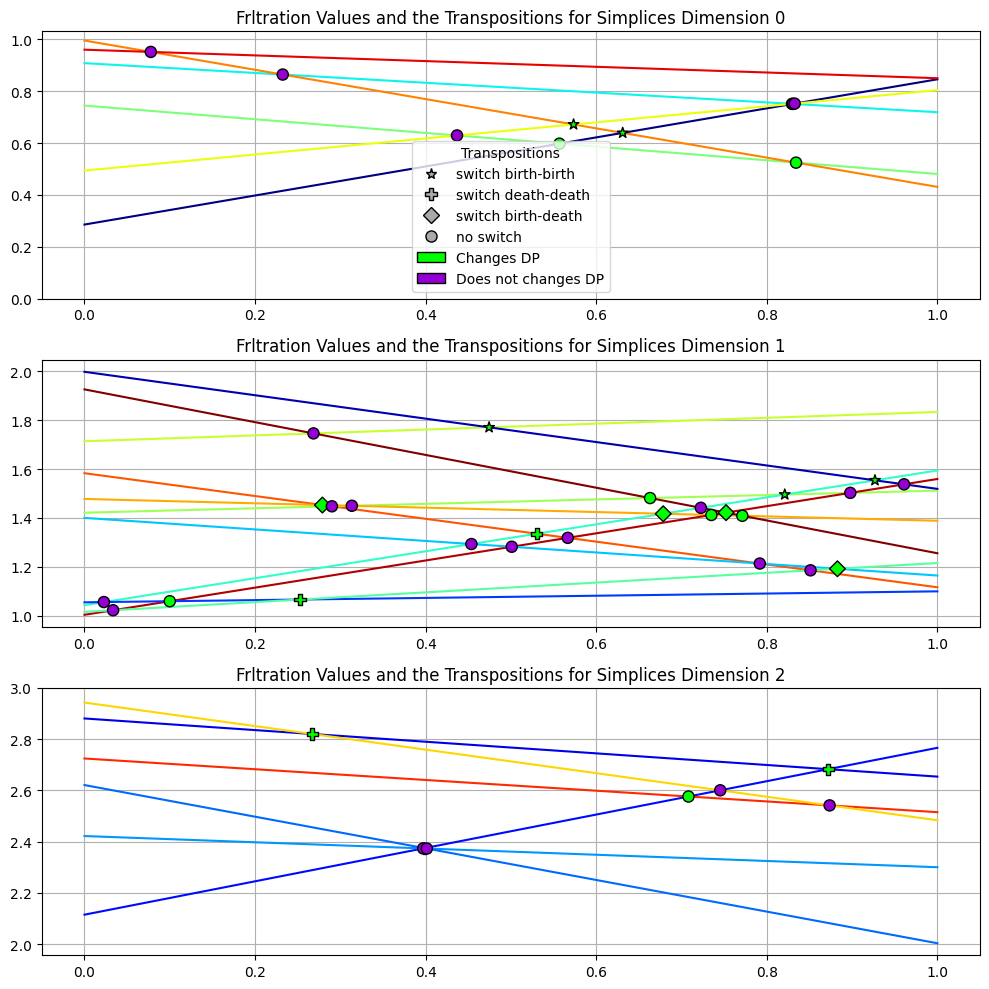

In [15]:
plot_category_markers = {
    'switch birth-birth': '*', 
    'switch death-death': 'P', 
    'switch birth-death': 'D', 
    'no switch': 'o',
}

changing_colors = {
    True: 'lime', 
    False: 'darkviolet'
}



fig, axs = plt.subplots(3, figsize=[10, 10])

for dim in range(3):
    axs[dim].set_title(f'Frltration Values and the Transpositions for Simplices Dimension {dim}')
    for simplex, y0, y1, color in zip(simplices[dims == dim], filtration0[dims == dim], filtration1[dims == dim], colors[dims == dim]):
        axs[dim].plot([0, 1], [y0, y1], color=color)
    
    for category, marker in plot_category_markers.items():
        dfi = df_transpositions[(df_transpositions['dim'] == dim) & (df_transpositions['plot category'] == category)]
        x = dfi['time']
        y = dfi['value']
        point_colors = dfi['changing'].replace(changing_colors)
        
        axs[dim].scatter(x, y, marker=marker, color=point_colors, edgecolor='black', s=64, zorder=2, linewidth=1)
    
    axs[dim].set_yticks(np.linspace(dim, dim + 1, 6))
    axs[dim].grid(True)


custom_lines = [
    Line2D([], [], color='none', marker=marker, markerfacecolor='darkgrey', markeredgecolor='black',
           markersize=8, label=category) for category, marker in plot_category_markers.items()
] + [
    Patch(facecolor=changing_colors[True], edgecolor='black',label='Changes DP'), 
    Patch(facecolor=changing_colors[False], edgecolor='black',label='Does not changes DP'), 
]
axs[0].legend(handles=custom_lines, title='Transpositions')

plt.tight_layout()
plt.show()

# Height Model
In this model we define the simplicial complex by the Delauney triangulation of $n$ points uniformly distributed in $[0, 1]^d$ ($d = 2$).

After this we define the uniformly distributed in $[0, 1]$ height for each vertex. Then the filtration value of the simplex will be the maximum haight of its vertices.

## Generate a Complex and 2 Height Vectors

In [16]:
def get_heights_stree(heights, triangles) -> gh.SimplexTree:
    # returns the SimplexTree coresponding the given heights vector and the triangulation
    heights = np.asarray(heights)
    stree = gh.SimplexTree()
    for triangle in triangles:
        for i in range(1, len(triangle) + 1):
            for simplex in itertools.combinations(triangle, r=i):
                value = max(heights[list(simplex)])
                stree.insert(simplex, value)
    return stree

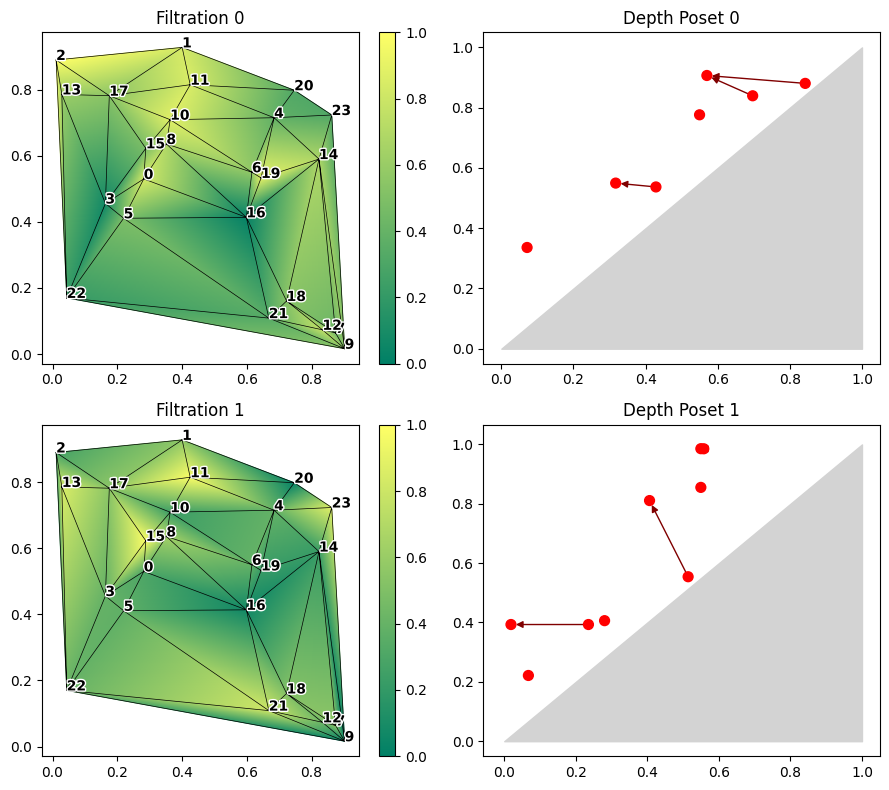

In [17]:
n = 24
complex_dimension = 2
points = np.random.random([n, complex_dimension])

simplices = np.array([tuple(s) for s, _ in gh.AlphaComplex(points).create_simplex_tree().get_simplices()], dtype=object)
simplices = simplices[np.argsort([len(s) for s in simplices])]
dims = np.vectorize(len)(simplices) - 1

triangles = simplices[dims == 2]

heights0 = np.random.random(n)
heights1 = np.random.random(n)

stree0 = get_heights_stree(heights0, triangles)
stree1 = get_heights_stree(heights1, triangles)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

intersecting_node_sources = {node.source for node in dp0.nodes} & {node.source for node in dp1.nodes}
intersecting_edge_sources = {(e0.source, e1.source) for e0, e1 in dp0.edges} & {(e0.source, e1.source) for e0, e1 in dp1.edges}


fig, axs = plt.subplots(2, 2, figsize=(9, 8))

cmap = 'summer'
triang = tri.Triangulation(points[:, 0], points[:, 1], np.array(list(triangles)))
for i, (heightsi, dpi) in enumerate(zip([heights0, heights1], [dp0, dp1])):
    axs[i, 0].set_title(f'Filtration {i}')
    sm = axs[i, 0].tripcolor(triang, heightsi, shading='gouraud', cmap=cmap, vmin=0, vmax=1)
    axs[i, 0].triplot(triang, color='black', linewidth=0.5)
    enumerate_points(points, ax=axs[i, 0], weight='semibold', forewidth=2)
    plt.colorbar(sm, ax=axs[i, 0])

    node_colors = ['cyan' if node.source in intersecting_node_sources else 'red' for node in dpi.nodes]
    edge_colors = ['navy' if (e0.source, e1.source) in intersecting_edge_sources else 'maroon' for e0, e1 in dpi.edges]

    axs[i, 1].set_title(f'Depth Poset {i}')
    nx.draw_networkx(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[i, 1], 
                     node_size=50, node_color=node_colors, edge_color=edge_colors, 
                     hide_ticks=False, with_labels=False)
    
    axs[i, 1].fill_between([0, 1], [0, 0], [0, 1], color='lightgrey')

plt.tight_layout()
plt.show()

/tmp/ipykernel_100289/659470295.py:17: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


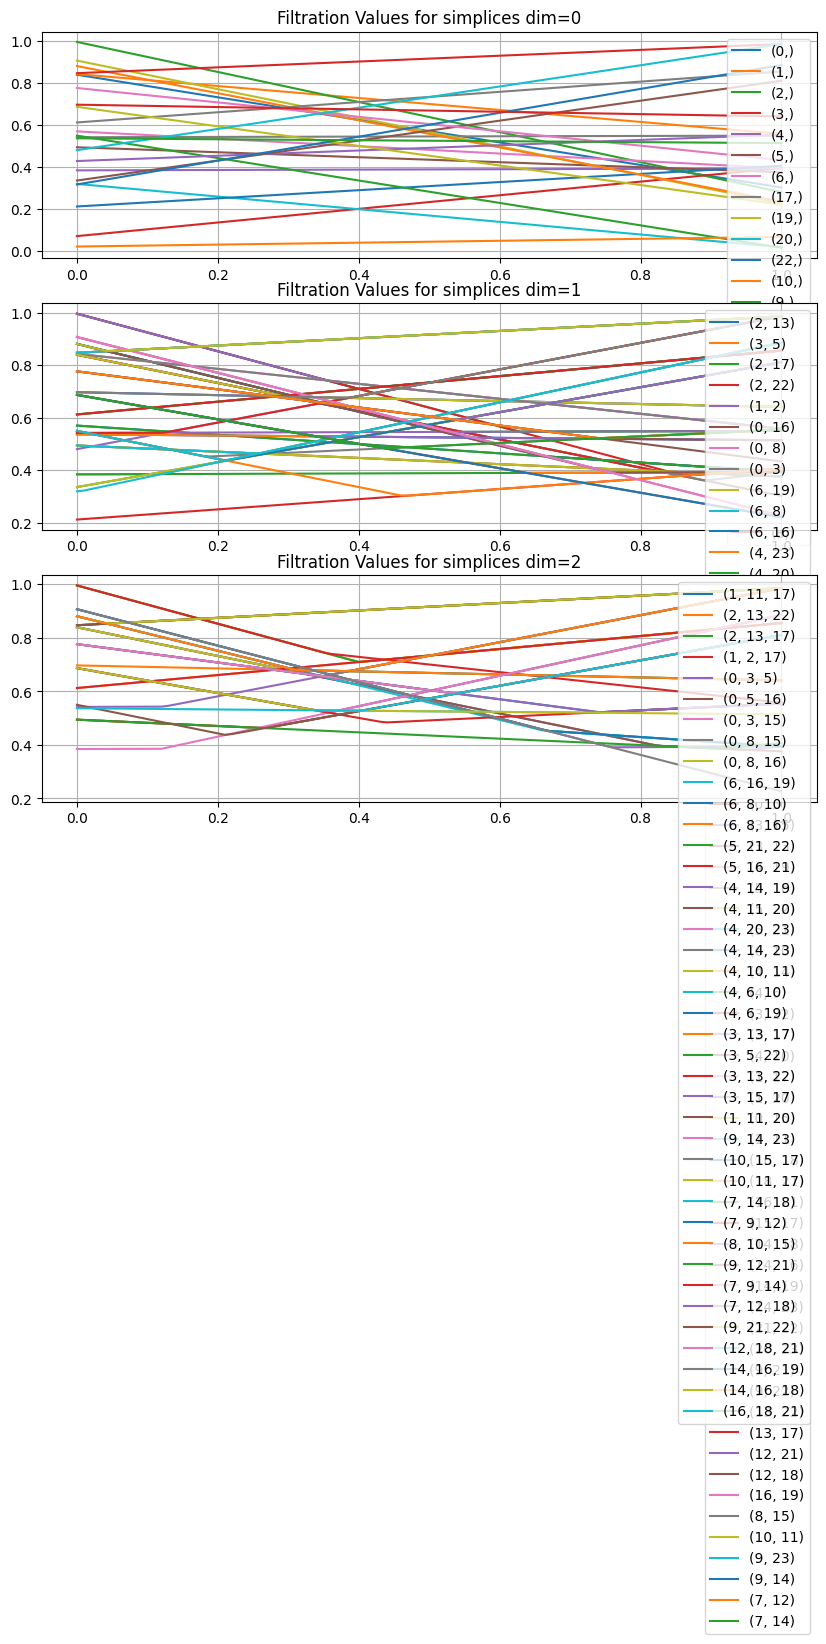

In [18]:
ts = np.linspace(0, 1, 101)
ys = []

for t in ts:
    heights = (1 - t)*heights0 + t*heights1
    stree = get_heights_stree(heights, triangles)
    ys.append({simplex: stree.filtration(simplex) for simplex in simplices})

ys = pd.DataFrame(ys, index=ts)

fig, axs = plt.subplots(3, figsize=(10, 10))
for dim in range(3):
    axs[dim].set_title(f'Filtration Values for simplices dim={dim}')
    ys[simplices[dims == dim]].plot(ax=axs[dim])
    axs[dim].grid(True)

plt.tight_layout()
plt.show()

## Studying 1 Transposition

In [19]:
cross_parameters = get_cross_parameters(heights0, heights1)

vertices0, vertices1 = np.argwhere(~np.isnan(cross_parameters)).transpose()
vertices0, vertices1 = vertices0[vertices1 > vertices0], vertices1[vertices1 > vertices0]
df_height_transpositions = pd.DataFrame(
    {
        'Vertex 0': vertices0, 
        'Vertex 1': vertices1, 
        'Time': cross_parameters[vertices0, vertices1]
    }
)
df_height_transpositions['Value'] = df_height_transpositions.apply(lambda row: ((1 - row['Time'])*heights0 + row['Time']*heights[1])[int(row['Vertex 0'])], axis=1)

eps = np.unique(np.concatenate([df_height_transpositions['Time'].values, [0, 1]]))
eps = 0.5*min(eps[1:] - eps[:-1])
print(f'eps = {eps:.1e}')


print(f'df_height_transpositions.shape = {df_height_transpositions.shape}')
df_height_transpositions.head()

eps = 3.6e-05
df_height_transpositions.shape = (144, 4)


/tmp/ipykernel_100289/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


,Vertex 0,Vertex 1,Time,Value
0,0,2,0.876047,0.592732
1,0,3,0.891949,0.588254
2,0,4,0.833924,0.604594
3,0,5,0.824888,0.607139
4,0,6,0.746640,0.629175


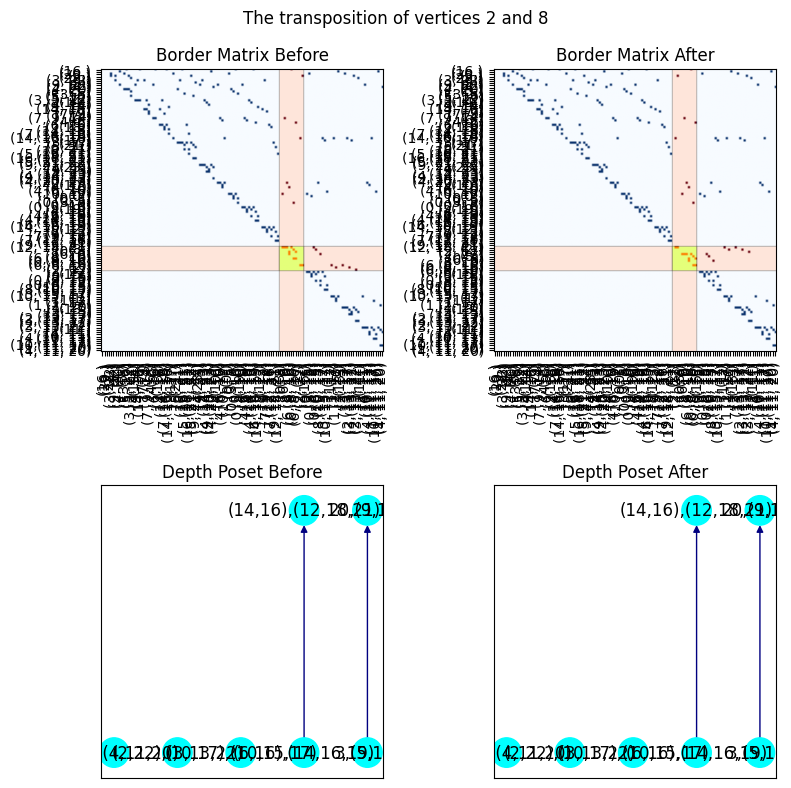

In [20]:
i = np.random.choice(df_height_transpositions.index)
time = df_height_transpositions.loc[i, 'Time']
vertex0, vertex1 = df_height_transpositions.loc[i, ['Vertex 0', 'Vertex 1']].astype(int)
simplex0, simplex1 = (vertex0, ), (vertex1, )


time_before = time - eps
heights_before = heights0*(1 - time_before) + heights1*time_before
stree_before = get_heights_stree(heights_before, triangles)
dp_before = DepthPoset.from_simplex_tree(stree_before)
order_before, matrix_before = depth.get_ordered_border_matrix_from_simplex_tree(stree_before)
order_before = np.array(order_before, dtype=object)

time_after = time + eps
heights_after = heights0*(1 - time_after) + heights1*time_after
stree_after = get_heights_stree(heights_after, triangles)
order_after, matrix_after = depth.get_ordered_border_matrix_from_simplex_tree(stree_after)
dp_after = DepthPoset.from_simplex_tree(stree_after)
order_after = np.array(order_after, dtype=object)

intersecting_node_sources = {node.source for node in dp_before.nodes} & {node.source for node in dp_after.nodes}
intersecting_edge_sources = {(e0.source, e1.source) for e0, e1 in dp_before.edges} & {(e0.source, e1.source) for e0, e1 in dp_after.edges}


fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle(f'The transposition of vertices {vertex0} and {vertex1}')

for i, (heightsi, titlei) in enumerate(zip([heights_before, heights_after], ['Before', 'After'])):
    streei = get_heights_stree(heightsi, triangles)
    dpi = DepthPoset.from_simplex_tree(streei)
    orderi, matrixi = depth.get_ordered_border_matrix_from_simplex_tree(streei)

    #axs[0, i].set_title(f'Complex {titlei}')
    #sm = axs[0, i].tripcolor(triang, heightsi, shading='gouraud', cmap=cmap, vmin=0, vmax=1)
    #axs[0, i].triplot(triang, color='black', linewidth=0.5)
    #enumerate_points(points, ax=axs[0, i], weight='semibold', forewidth=2)
    #plt.colorbar(sm, ax=axs[0, i])

    axs[0, i].set_title(f'Border Matrix {titlei}')
    axs[0, i].imshow(matrixi, cmap='Blues', vmin=0, vmax=1)
    matrixj = matrixi.astype(float)
    matrixj[order_before == order_after, :] = np.nan
    axs[0, i].imshow(matrixj, cmap='Reds', vmin=-0.1, vmax=1)
    matrixj = matrixi.astype(float)
    matrixj[:, order_before == order_after] = np.nan
    axs[0, i].imshow(matrixj, cmap='Reds', vmin=-0.1, vmax=1)
    matrixj = matrixi.astype(float)
    matrixj[order_before == order_after, :] = np.nan
    matrixj[:, order_before == order_after] = np.nan
    axs[0, i].imshow(matrixj, cmap='Wistia', vmin=0.0, vmax=1)


    axs[0, i].set_xticks(np.arange(len(orderi)), orderi, rotation=90)
    axs[0, i].set_yticks(np.arange(len(orderi)), orderi, rotation=0)

    axs[1, i].set_title(f'Depth Poset {titlei}')
    node_colors = ['cyan' if node.source in intersecting_node_sources else 'red' for node in dpi.nodes]
    edge_colors = ['navy' if (e0.source, e1.source) in intersecting_edge_sources else 'maroon' for e0, e1 in dpi.edges]

    nx.draw_networkx(dpi.get_transitive_reduction(), pos=dpi.hasse_layout(), ax=axs[1, i], 
                     node_size=450, node_color=node_colors, edge_color=edge_colors, 
                     hide_ticks=True, with_labels=True)
    
plt.tight_layout()
plt.show()

In [21]:
def get_transpositions_by_positions(pos0, pos1):
    # 
    if len(pos0) != len(pos1):
        raise ValueError('Arguments pos0, pos1 should have same length.')
    pos0 = np.array(pos0, dtype=int)
    pos1 = np.array(pos1, dtype=int)
    res = []
    for i0, i1 in zip(pos0, pos1):
        if i0 < i1:
            res.append(np.transpose([np.arange(i0, i1), np.arange(i0, i1) + 1]))
        if i1 < i0:
            res.append(np.transpose([np.arange(i0, i1, -1) - 1, np.arange(i0, i1, -1)]))
    if len(res) > 0:
        res = np.concatenate(res, axis=0)
    else:
        res = np.zeros([0, 2], dtype=int)
    return res

In [22]:
def get_series_of_transpositions(vertex0, vertex1, order_before, order_after, direction_up=True) -> list:
    """
    """
    simplex0, simplex1 = (vertex0, ), (vertex1, )
    order_before = np.array(order_before, dtype=object)
    order_after = np.array(order_after, dtype=object)

    if len(order_before) != len(set(order_before)):
        raise ValueError(f'Some simplex is repeated in order_before.')
    if len(order_after) != len(set(order_after)):
        raise ValueError(f'Some simplex is repeated in order_after.')
    if set(order_before) != set(order_after):
        raise ValueError('The orders should contain similar simplices.')
    if not((simplex0 in set(order_before)) and (simplex1 in set(order_before))):
        raise ValueError(f'The transposing simplices {simplex0}, {simplex1} are not in the orders.')

    if list(order_before).index(simplex0) > list(order_before).index(simplex1):
        vertex0, vertex1 = vertex1, vertex0
        simplex0, simplex1 = simplex1, simplex0

    # condition: thse simplix does not contain vertex given later than transposing 
    vertices = order_before[np.vectorize(lambda s: len(s) == 1)(order_before)]
    vertices = np.vectorize(lambda s: s[0])(vertices)
    later_vertices = set(vertices[list(vertices).index(vertex1) + 1:])
    not_late = np.vectorize(lambda s: len(set(s) & later_vertices) == 0)

    # conditions: simplex contain transposing vertex
    contain_vertex0 = np.vectorize(lambda s: (vertex0 in s))
    contain_vertex1 = np.vectorize(lambda s: (vertex1 in s))
    
    id_group0_before = np.where(contain_vertex0(order_before) & ~contain_vertex1(order_before) & not_late(order_before))[0]
    id_group1_before = np.where(~contain_vertex0(order_before) & contain_vertex1(order_before) & not_late(order_before))[0]
    id_group2_before = np.where(contain_vertex0(order_before) & contain_vertex1(order_before) & not_late(order_before))[0]

    id_group0_after = np.where(contain_vertex0(order_after) & ~contain_vertex1(order_after) & not_late(order_after))[0]
    id_group1_after = np.where(~contain_vertex0(order_after) & contain_vertex1(order_after) & not_late(order_after))[0]
    id_group2_after = np.where(contain_vertex0(order_after) & contain_vertex1(order_after) & not_late(order_after))[0]

    len0 = len(id_group0_before)
    len1 = len(id_group1_before)
    len2 = len(id_group2_before)

    ids = np.sort(np.concatenate([id_group0_before, id_group1_before, id_group2_before]))
    ids_after = np.sort(np.concatenate([id_group0_after, id_group1_after, id_group2_after]))
    if (ids != ids_after).any() or (ids[1:] != ids[:-1] + 1).any():
        msg = 'The transpositions should happen on subsequence of neighbouring elements.\n'
        msg += 'So the order_before and order_after should not contain the simplices not containing transposing vertices between them'
        msg += f'\nids0: {ids}\nids1: {ids_after}'
        df_msg = pd.DataFrame({'order': order_before})
        df_msg['Group'] = np.nan
        df_msg.loc[id_group0_before, 'Group'] = 0
        df_msg.loc[id_group1_before, 'Group'] = 1
        df_msg.loc[id_group2_before, 'Group'] = 2
        msg  += '\n' + str(df_msg)
        raise ValueError(msg)
    
    if direction_up:
        id_group0_middle = ids[len1: len0 + len1]
        id_group1_middle = ids[:len1]
        id_group2_middle = ids[len0 + len1:]

        transpositions = [get_transpositions_by_positions(id_group1_before, id_group1_middle), 
                          get_transpositions_by_positions(id_group2_middle, id_group2_after)]
        transpositions = np.concatenate(transpositions, axis=0)
        
    else:
        id_group0_middle = ids[:len0]
        id_group1_middle = ids[len0: len0 + len1]
        id_group2_middle = ids[len0 + len1:]
        
        transpositions = [get_transpositions_by_positions(id_group2_before[::-1], id_group2_middle[::-1]), 
                          get_transpositions_by_positions(id_group0_middle[::-1], id_group0_after[::-1])]
        transpositions = np.concatenate(transpositions, axis=0)

    return transpositions

In [23]:
def get_series_of_orders(vertex0, vertex1, order_before, order_after, direction_up=True):
    # 
    order_before = np.array(order_before, dtype=object)
    order_after = np.array(order_after, dtype=object)

    transpositions = get_series_of_transpositions(vertex0, vertex1, order_before, order_after, direction_up=direction_up)
    current_order = order_before.copy()
    orders = [current_order.copy()]
    for index0, index1 in transpositions:
        current_order[[index0, index1]] = current_order[[index1, index0]]
        orders.append(current_order.copy())
    orders = np.array(orders)

    assert (orders[0] == order_before).all()
    assert (orders[-1] == order_after).all()
    assert ((orders[1:] != orders[:-1]).sum(axis=1) == 2).all()
    
    return orders

In [24]:
def get_df_of_transpositions_by_transposing_vertices(vertex0, vertex1, order_before, order_after, direction_up=True) -> pd.DataFrame:
    # 
    transpositions = get_series_of_transpositions(vertex0, vertex1, order_before, order_after, direction_up=direction_up)
    orders = get_series_of_orders(vertex0, vertex1, order_before, order_after, direction_up=direction_up)

    df = pd.DataFrame(
        {
            'order before': list(orders[:-1]), 
            'order after': list(orders[1:]), 
            'Index 0': transpositions[:, 0], 
            'Index 1': transpositions[:, 1], 
        }
    )
    df['Simplex 0'] = df.apply(lambda row: row['order before'][row['Index 0']], axis=1)
    df['Simplex 1'] = df.apply(lambda row: row['order before'][row['Index 1']], axis=1)
    df['stree before'] = df['order before'].apply(get_stree_from_order)
    df['stree after'] = df['order after'].apply(get_stree_from_order)
    
    df['transposition object'] = df.apply(lambda row: Transposition.from_simplex_tree(stree=row['stree before'], simplex0=row['Simplex 0'], simplex1=row['Simplex 1']), axis=1)
    df['dim'] = df['transposition object'].apply(lambda i: i.dim)
    df['dim'] = df['dim'].astype('Int32')
    df['type'] = df['transposition object'].apply(lambda i: i.get_transposition_type())
    df['switch'] = df['transposition object'].apply(lambda i: i.get_switch_type())
    df['class'] = df.apply(lambda row: 'no switch' if row['switch'] in ['no switch', 'undefined'] else row['type'], axis=1)
    
    df['dp before'] = df['stree before'].apply(DepthPoset.from_simplex_tree)
    df['dp after'] = df['stree after'].apply(DepthPoset.from_simplex_tree)
    
    return df


In [25]:
transpositions_up = get_series_of_transpositions(vertex0, vertex1, order_before, order_after, direction_up=True)
transpositions_dn = get_series_of_transpositions(vertex0, vertex1, order_before, order_after, direction_up=False)
orders_up = get_series_of_orders(vertex0, vertex1, order_before, order_after, direction_up=True)
orders_dn = get_series_of_orders(vertex0, vertex1, order_before, order_after, direction_up=False)

df_transpositions = [get_df_of_transpositions_by_transposing_vertices(vertex0, vertex1, order_before, order_after, direction_up=True), 
                     get_df_of_transpositions_by_transposing_vertices(vertex0, vertex1, order_before, order_after, direction_up=False)]
for i in range(len(df_transpositions)):
    df_transpositions[i].insert(0, 'path index', i)
df_transpositions = pd.concat(df_transpositions).reset_index(drop=False).rename(columns={'index': 'index in path'})

df_transpositions['order before'] = df_transpositions['order before'].apply(tuple)
df_transpositions['order after'] = df_transpositions['order after'].apply(tuple)

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

df_transpositions.shape = (48, 17)


,index in path,path index,order before,order after,Index 0,Index 1,Simplex 0,Simplex 1,stree before,stree after,transposition object,dim,type,switch,class,dp before,dp after
0,0,0,"((16,), (20,), (3,), (22,), (3, 22), (9,), (9,...","((16,), (20,), (3,), (22,), (3, 22), (9,), (9,...",87,88,"(6, 8, 16)","(2,)",<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(6, 8, 16), (2,)>",<NA>,birth-death,no switch,no switch,<src.depth.DepthPoset object at 0x790396a6caa0>,<src.depth.DepthPoset object at 0x79039676b740>
1,1,0,"((16,), (20,), (3,), (22,), (3, 22), (9,), (9,...","((16,), (20,), (3,), (22,), (3, 22), (9,), (9,...",86,87,"(0, 8, 16)","(2,)",<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(0, 8, 16), (2,)>",<NA>,birth-death,no switch,no switch,<src.depth.DepthPoset object at 0x790396a169f0>,<src.depth.DepthPoset object at 0x790396790a70>
2,2,0,"((16,), (20,), (3,), (22,), (3, 22), (9,), (9,...","((16,), (20,), (3,), (22,), (3, 22), (9,), (9,...",85,86,"(8, 16)","(2,)",<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(8, 16), (2,)>",<NA>,birth-birth,no switch,no switch,<src.depth.DepthPoset object at 0x790396a6dee0>,<src.depth.DepthPoset object at 0x790396791490>
3,3,0,"((16,), (20,), (3,), (22,), (3, 22), (9,), (9,...","((16,), (20,), (3,), (22,), (3, 22), (9,), (9,...",84,85,"(6, 8, 10)","(2,)",<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(6, 8, 10), (2,)>",<NA>,birth-death,no switch,no switch,<src.depth.DepthPoset object at 0x790396a6ec30>,<src.depth.DepthPoset object at 0x790396792840>
4,4,0,"((16,), (20,), (3,), (22,), (3, 22), (9,), (9,...","((16,), (20,), (3,), (22,), (3, 22), (9,), (9,...",83,84,"(8, 10)","(2,)",<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(8, 10), (2,)>",<NA>,birth-birth,no switch,no switch,<src.depth.DepthPoset object at 0x790396a6faa0>,<src.depth.DepthPoset object at 0x790396793aa0>


In [26]:
df_orders = [df_transpositions[['order before', 'stree before', 'dp before']].rename(columns=lambda s: s.replace(' before', '')), 
             df_transpositions[['order after', 'stree after', 'dp after']].rename(columns=lambda s: s.replace(' after', '')), 
             ]
df_orders = pd.concat(df_orders)
df_orders = df_orders.groupby('order').first().reset_index()

dp_types = []
for dp in df_orders['dp']:
    if not dp in dp_types:
        dp_types.append(dp)

df_orders['dp type'] = df_orders['dp'].apply(dp_types.index)

print(f'df_orders.shape = {df_orders.shape}')
df_orders.head()

df_orders.shape = (46, 4)


,order,stree,dp,dp type
0,"((16,), (20,), (3,), (22,), (3, 22), (9,), (9,...",<gudhi.simplex_tree.SimplexTree object at 0x79...,<src.depth.DepthPoset object at 0x79039663b620>,0
1,"((16,), (20,), (3,), (22,), (3, 22), (9,), (9,...",<gudhi.simplex_tree.SimplexTree object at 0x79...,<src.depth.DepthPoset object at 0x79039674f0e0>,0
2,"((16,), (20,), (3,), (22,), (3, 22), (9,), (9,...",<gudhi.simplex_tree.SimplexTree object at 0x79...,<src.depth.DepthPoset object at 0x790396768d70>,0
3,"((16,), (20,), (3,), (22,), (3, 22), (9,), (9,...",<gudhi.simplex_tree.SimplexTree object at 0x79...,<src.depth.DepthPoset object at 0x79039674f2c0>,0
4,"((16,), (20,), (3,), (22,), (3, 22), (9,), (9,...",<gudhi.simplex_tree.SimplexTree object at 0x79...,<src.depth.DepthPoset object at 0x79039674ef30>,0


In [27]:
from matplotlib.colors import ListedColormap
import colorsys

def pastelize_cmap(cmap_name='gist_rainbow', n_colors=256, lightness=0.8, saturation=0.5):
    base = plt.get_cmap(cmap_name)
    colors = []

    for i in np.linspace(0, 1, n_colors):
        r, g, b, _ = base(i)
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        r_p, g_p, b_p = colorsys.hls_to_rgb(h, lightness, saturation)
        colors.append((r_p, g_p, b_p))

    return ListedColormap(colors, name=f'{cmap_name}_pastel')

cmap = pastelize_cmap()

/home/feodor/.local/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


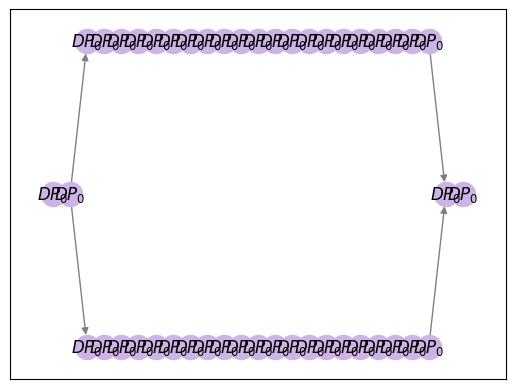

In [28]:
# Changes
g_transposition_orders = nx.DiGraph()
g_transposition_orders.add_nodes_from(df_orders['order'])
g_transposition_orders.add_edges_from(df_transpositions[['order before', 'order after']].values)

pos = nx.nx_agraph.graphviz_layout(g_transposition_orders, prog="dot", args='-Grankdir=LR')
node_labels = df_orders.groupby('order')['dp type'].first().apply(lambda i: f'$DP_{{{str(i)}}}$')
if len(dp_types) == 1:
    node_colors = cmap(np.random.random())
else:
    node_colors = df_orders.groupby('order')['dp type'].first().apply(lambda i: cmap(i/df_orders['dp type'].max()))
    node_colors = node_colors.apply(lambda v: '#{:02X}{:02X}{:02X}'.format(*(255*np.array(v)[:3]).astype(int)))

transpsoition_class_colors = {'birth-birth': 'green', 'birth-death': 'blue', 'death-death': 'red', 'no switch': 'grey', }
edge_colors = df_transpositions.groupby(['order before', 'order after'])['class'].first().replace(transpsoition_class_colors)


nx.draw_networkx(g_transposition_orders, pos=pos, labels=node_labels, node_color=node_colors, edge_color=edge_colors)

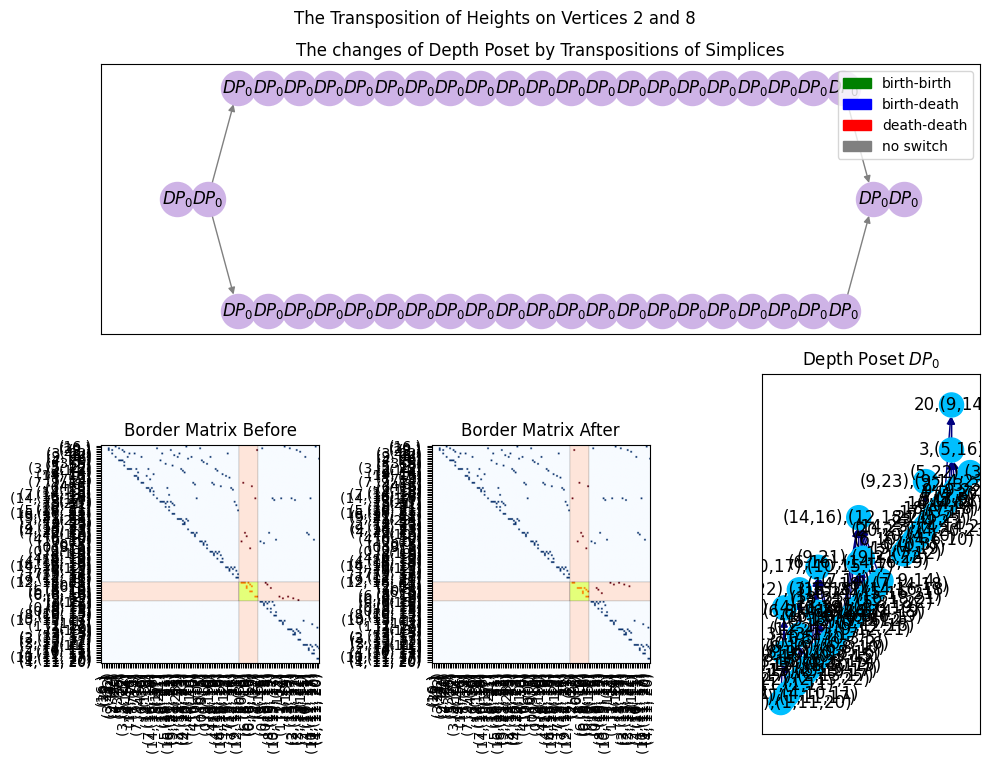

In [29]:
if len(dp_types) == 1:
    fig = plt.figure(figsize=(10 * len(dp_types), 8))
    gs = gridspec.GridSpec(2, 3, height_ratios=[3, 4])
    ax_bottom = [fig.add_subplot(gs[1, i]) for i in range(3)]
else:
    k = np.ceil(len(dp_types)/2).astype(int)
    fig = plt.figure(figsize=(3 * len(dp_types), 10))
    gs = gridspec.GridSpec(3, k + 1, height_ratios=[3, 4, 4])
    ax_bottom = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[2, 0])] + [fig.add_subplot(gs[1 + i//k, i%k + 1]) for i in range(len(dp_types))]

ax_top = fig.add_subplot(gs[0, :])
fig.suptitle(f'The Transposition of Heights on Vertices {vertex0} and {vertex1}')


# plot changes graph
ax_top.set_title(f'The changes of Depth Poset by Transpositions of Simplices')
nx.draw_networkx(g_transposition_orders, pos=pos, node_size=600, labels=node_labels, node_color=node_colors, edge_color=edge_colors,  
                 ax=ax_top, hide_ticks=True)
legend_arrows = [
    FancyArrow(0, 0, 1.2, 0, width=0.01, head_width=0.03, head_length=0.1, color=color, label=label) for label, color in transpsoition_class_colors.items()
]
ax_top.legend(handles=legend_arrows)


# Depth Posets
general_nodes = set(dp_types[0].nodes)
general_edges = set(dp_types[0].get_transitive_closure().edges)
for dp in dp_types:
    general_nodes = general_nodes & set(dp.nodes)
    general_edges = general_edges & set(dp.get_transitive_closure().edges)

for idp, dp in enumerate(dp_types):
    ax_bottom[idp + 2].set_title(f'Depth Poset $DP_{{{idp}}}$')

    dp_node_colors = ['deepskyblue' if node in general_nodes else 'orange' for node in dp.nodes]
    dp_edge_colors = ['navy' if edge in general_edges else 'maroon' for edge in dp.get_transitive_reduction().edges]

    nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.hasse_layout(alignment_slope=0.1),
                     node_color=dp_node_colors, edge_color=dp_edge_colors, with_labels=True,
                     ax=ax_bottom[idp + 2])

# Border Matrices
for i, (heightsi, titlei) in enumerate(zip([heights_before, heights_after], ['Before', 'After'])):
    streei = get_heights_stree(heightsi, triangles)
    dpi = DepthPoset.from_simplex_tree(streei)
    orderi, matrixi = depth.get_ordered_border_matrix_from_simplex_tree(streei)

    ax_bottom[i].set_title(f'Border Matrix {titlei}')
    ax_bottom[i].imshow(matrixi, cmap='Blues', vmin=0, vmax=1)
    matrixj = matrixi.astype(float)
    matrixj[order_before == order_after, :] = np.nan
    ax_bottom[i].imshow(matrixj, cmap='Reds', vmin=-0.1, vmax=1)
    matrixj = matrixi.astype(float)
    matrixj[:, order_before == order_after] = np.nan
    ax_bottom[i].imshow(matrixj, cmap='Reds', vmin=-0.1, vmax=1)
    matrixj = matrixi.astype(float)
    matrixj[order_before == order_after, :] = np.nan
    matrixj[:, order_before == order_after] = np.nan
    ax_bottom[i].imshow(matrixj, cmap='Wistia', vmin=0.0, vmax=1)


    ax_bottom[i].set_xticks(np.arange(len(orderi)), orderi, rotation=90)
    ax_bottom[i].set_yticks(np.arange(len(orderi)), orderi, rotation=0)


plt.tight_layout()
plt.show()

## Orders During Linear Homotopy of Heights

In [30]:
def get_vertex_transpositions(heights0, heights1):
    # 
    cross_parameters = get_cross_parameters(heights0, heights1)
    cross_parameters[np.tril(np.ones(cross_parameters.shape, dtype=bool))] = np.nan
    vtransp_indices = np.argwhere(~np.isnan(cross_parameters))
    vtransp_times = cross_parameters[vtransp_indices[:, 0], vtransp_indices[:, 1]]
    vtransp_heights = heights0[vtransp_indices[:, 0]]*(1 - vtransp_times) + heights1[vtransp_indices[:, 0]]*vtransp_times

    vtransp_indices = vtransp_indices[np.argsort(vtransp_times)]
    vtransp_heights = vtransp_heights[np.argsort(vtransp_times)]
    vtransp_times = vtransp_times[np.argsort(vtransp_times)]

    return vtransp_indices, vtransp_times, vtransp_heights

In [31]:
def get_between_crosses(y0, y1, t0=0, t1=1):
    # 
    if t1 < t0:
        t1, t0 = t0, t1
    m = get_cross_parameters(heights0, heights1, t0=t0, t1=t1, filter_outside=False)
    m[np.tril(np.ones(m.shape, dtype=bool))] = np.nan
    r = np.sort(m[(m >= t0)&(m <= t1)])
    r = np.concatenate([[m[m < t0].max()], r, [m[m > t1].min()]])
    r = 0.5*(r[1:] + r[:-1])
    return r

In [32]:
def get_transpositions_during_homotopy_between_heights(triangles, heights0, heights1, direction_up=True, with_bar=True):
    # 
    vtransp_indices, vtransp_times, vtransp_heights = get_vertex_transpositions(heights0, heights1)
    between_times = get_between_crosses(heights0, heights1)
    assert len(between_times) == len(vtransp_times) + 1

    between_heights = [heights0*(1 - time) + heights1*time for time in between_times]
    between_strees = [get_heights_stree(heights, triangles) for heights in between_heights]
    between_orders = [[tuple(s) for s, _ in stree.get_filtration()] for stree in between_strees]

    if with_bar:
        pbar = tqdm(total=len(vtransp_times), desc='Vertex transpositions')
    df_vtransp = []
    for (vertex0, vertex1), vtransp_time, vtransp_height, order_before, order_after in zip(
        vtransp_indices, vtransp_times, vtransp_heights, between_orders[:-1], between_orders[1:]
    ):
        df_vtransp.append(
            get_df_of_transpositions_by_transposing_vertices(vertex0, vertex1, order_before, order_after, direction_up=direction_up)            
        )
        df_vtransp[-1].insert(0, 'Time', vtransp_time)
        df_vtransp[-1].insert(1, 'Value', vtransp_height)
        df_vtransp[-1].insert(2, 'Vertex 0', vertex0)
        df_vtransp[-1].insert(3, 'Vertex 1', vertex1)
        if with_bar:
            pbar.update(1)
    if with_bar:
        pbar.close()
    df_vtransp = pd.concat(df_vtransp).reset_index(drop=False).rename(columns={'index': 'index in vetex transposition'})
    
    return df_vtransp

In [33]:
dfs_transpositions_during_homotopy = [
    get_transpositions_during_homotopy_between_heights(triangles, heights0, heights1, direction_up=True), 
    get_transpositions_during_homotopy_between_heights(triangles, heights0, heights1, direction_up=False)
]
for df in dfs_transpositions_during_homotopy:
    orders = np.array(list(df['order before']))
    assert ((orders[1:] != orders[:-1]).sum(axis=1) == 2).all()

    orders = np.array(list(df['order after']))
    assert ((orders[1:] != orders[:-1]).sum(axis=1) == 2).all()

for i in range(len(dfs_transpositions_during_homotopy)):
    dfs_transpositions_during_homotopy[i] = dfs_transpositions_during_homotopy[i].reset_index(drop=False).rename(columns={'index': 'index in path'})
    dfs_transpositions_during_homotopy[i].insert(0, 'path index', i)


assert [x.shape for x in dfs_transpositions_during_homotopy[1:]] == [x.shape for x in dfs_transpositions_during_homotopy[:-1]]
df_transpositions_during_homotopy = pd.concat(dfs_transpositions_during_homotopy).reset_index(drop=True)

df_transpositions_during_homotopy['order before'] = df_transpositions_during_homotopy['order before'].apply(tuple)
df_transpositions_during_homotopy['order after'] = df_transpositions_during_homotopy['order after'].apply(tuple)

print(f'df_transpositions_during_homotopy.shape = {df_transpositions_during_homotopy.shape}')
df_transpositions_during_homotopy.head()

/tmp/ipykernel_100289/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


Vertex transpositions:   0%|          | 0/144 [00:00<?, ?it/s]

self.index1 - self.index0 != 1
self.index1 - self.index0 != 1


/tmp/ipykernel_100289/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


Vertex transpositions:   0%|          | 0/144 [00:00<?, ?it/s]

self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
df_transpositions_during_homotopy.shape = (9482, 22)


,path index,index in path,index in vetex transposition,Time,Value,Vertex 0,Vertex 1,order before,order after,Index 0,...,Simplex 1,stree before,stree after,transposition object,dim,type,switch,class,dp before,dp after
0,0,0,0,0.003220,0.318917,20,23,"((16,), (3,), (22,), (3, 22), (23,), (20,), (2...","((16,), (3,), (22,), (3, 22), (20,), (23,), (2...",4,...,"(20,)",<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(23,), (20,)>",0,birth-birth,switch forward,birth-birth,<src.depth.DepthPoset object at 0x790394740c80>,<src.depth.DepthPoset object at 0x7903946f2ed0>
1,0,1,0,0.014262,0.542048,9,17,"((16,), (3,), (22,), (3, 22), (20,), (23,), (2...","((16,), (3,), (22,), (3, 22), (20,), (23,), (2...",33,...,"(9,)",<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(3, 15, 17), (9,)>",<NA>,birth-death,no switch,no switch,<src.depth.DepthPoset object at 0x79039453bc80>,<src.depth.DepthPoset object at 0x790394454e30>
2,0,2,1,0.014262,0.542048,9,17,"((16,), (3,), (22,), (3, 22), (20,), (23,), (2...","((16,), (3,), (22,), (3, 22), (20,), (23,), (2...",32,...,"(9,)",<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(15, 17), (9,)>",<NA>,birth-birth,no switch,no switch,<src.depth.DepthPoset object at 0x790394558e30>,<src.depth.DepthPoset object at 0x790394456360>
3,0,3,2,0.014262,0.542048,9,17,"((16,), (3,), (22,), (3, 22), (20,), (23,), (2...","((16,), (3,), (22,), (3, 22), (20,), (23,), (2...",31,...,"(9,)",<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(3, 17), (9,)>",<NA>,birth-death,no switch,no switch,<src.depth.DepthPoset object at 0x79039455a090>,<src.depth.DepthPoset object at 0x7903944574d0>
4,0,4,3,0.014262,0.542048,9,17,"((16,), (3,), (22,), (3, 22), (20,), (23,), (2...","((16,), (3,), (22,), (3, 22), (20,), (23,), (2...",30,...,"(9,)",<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(17,), (9,)>",0,birth-birth,no switch,no switch,<src.depth.DepthPoset object at 0x79039453bc20>,<src.depth.DepthPoset object at 0x7903944741d0>


In [34]:
df_transpositions_during_homotopy[['type', 'switch']].value_counts().sort_index()

type            switch         
birth-birth     no switch          2317
                switch backward      16
                switch forward       15
birth-death     no switch          4686
                switch forward       48
birth-unpaired  undefined             4
death-death     no switch          2359
                switch backward      20
                switch forward       17
Name: count, dtype: int64

In [35]:
df_transpositions_during_homotopy['class'].value_counts()

class
no switch      9366
birth-death      48
death-death      37
birth-birth      31
Name: count, dtype: int64

In [36]:
df_orders_during_homotopy = pd.concat([
    df_transpositions_during_homotopy[['order before', 'stree before', 'dp before', 'type', 'switch', 'class']].rename(columns=lambda s: s.replace(' before', '')), 
    df_transpositions_during_homotopy[['order after', 'stree after', 'dp after', 'type', 'switch', 'class']].rename(columns=lambda s: s.replace(' after', '')), 
])

df_orders_during_homotopy = df_orders_during_homotopy.loc[df_orders_during_homotopy['order'].drop_duplicates().index]

dp_types = []
for dp in df_orders_during_homotopy['dp']:
    if not dp in dp_types:
        dp_types.append(dp)

df_orders_during_homotopy['dp type'] = df_orders_during_homotopy['dp'].apply(dp_types.index)


print(f'df_orders_during_homotopy.shape = {df_orders_during_homotopy.shape}')
df_orders_during_homotopy.head()

df_orders_during_homotopy.shape = (18232, 7)


,order,stree,dp,type,switch,class,dp type
0,"((16,), (3,), (22,), (3, 22), (23,), (20,), (2...",<gudhi.simplex_tree.SimplexTree object at 0x79...,<src.depth.DepthPoset object at 0x790394740c80>,birth-birth,switch forward,birth-birth,0
0,"((16,), (3,), (22,), (3, 22), (20,), (23,), (2...",<gudhi.simplex_tree.SimplexTree object at 0x79...,<src.depth.DepthPoset object at 0x7903946f2ed0>,birth-birth,switch forward,birth-birth,1
1,"((16,), (3,), (22,), (3, 22), (20,), (23,), (2...",<gudhi.simplex_tree.SimplexTree object at 0x79...,<src.depth.DepthPoset object at 0x79039453bc80>,birth-death,no switch,no switch,1
1,"((16,), (3,), (22,), (3, 22), (20,), (23,), (2...",<gudhi.simplex_tree.SimplexTree object at 0x79...,<src.depth.DepthPoset object at 0x790394454e30>,birth-death,no switch,no switch,1
2,"((16,), (3,), (22,), (3, 22), (20,), (23,), (2...",<gudhi.simplex_tree.SimplexTree object at 0x79...,<src.depth.DepthPoset object at 0x790394558e30>,birth-birth,no switch,no switch,1


### Visualise the Result

In [37]:
transposition_type_colors = {
    'no switch': 'grey', 
    'birth-birth': 'green', 
    'birth-death': 'blue', 
    'death-death': 'red', 
}

cmap = pastelize_cmap()
dp_type_colors = ['#{:02X}{:02X}{:02X}'.format(*v) for v in (cmap(np.linspace(0, 1, len(dp_types)))[:, :3]*255).astype(int)]
dp_type_colors = np.random.choice(dp_type_colors, len(dp_type_colors), replace=False)
dp_type_colors = {i: c for i, c in enumerate(dp_type_colors)}

/tmp/ipykernel_100289/3835317120.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/feodor/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


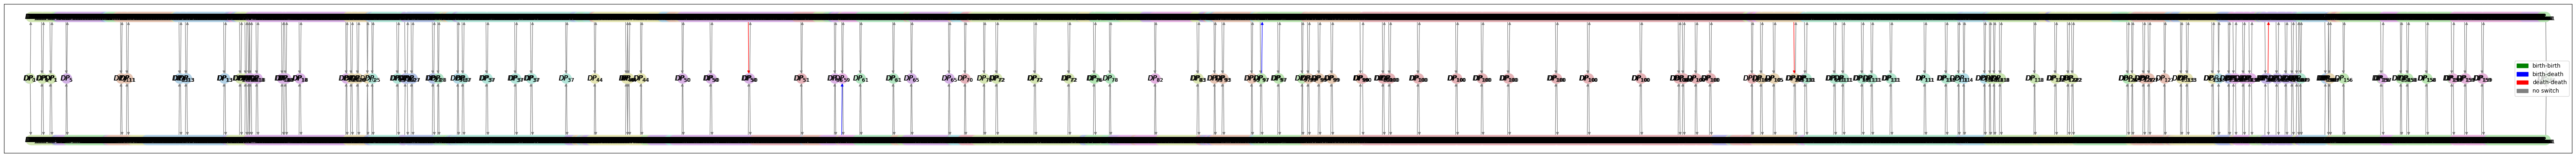

In [38]:
g_homotopy_transpositions = nx.DiGraph()
g_homotopy_transpositions.add_nodes_from(df_orders_during_homotopy['order'])
g_homotopy_transpositions.add_edges_from(df_transpositions_during_homotopy[['order before', 'order after']].values)

node_colors = df_orders_during_homotopy.groupby('order')['dp type'].first().replace(dp_type_colors)
node_labels = df_orders_during_homotopy.groupby('order')['dp type'].first().apply(lambda i: f'$DP_{{{str(i)}}}$')

node_colors = node_colors[list(g_homotopy_transpositions.nodes)]
node_labels = node_labels[list(g_homotopy_transpositions.nodes)]

pos = nx.shell_layout(g_homotopy_transpositions)
pos = nx.nx_agraph.graphviz_layout(g_homotopy_transpositions, prog="dot", args='-Grankdir=LR')

edge_colors = df_transpositions_during_homotopy.groupby(['order before', 'order after'])['class'].first().replace(transposition_type_colors)

plt.figure(figsize=(64, 4))
nx.draw_networkx(g_homotopy_transpositions, pos=pos, node_color=node_colors, labels=node_labels, edge_color=edge_colors)


legend_arrows = [
    FancyArrow(0, 0, 1.2, 0, width=0.01, head_width=0.03, head_length=0.1, color=color, label=label) for label, color in transpsoition_class_colors.items()
]
xlim0, xlim1 = np.array(list(pos.values()))[:, 0].min(), np.array(list(pos.values()))[:, 0].max()
xlim0, xlim1 = xlim0 - 0.01*(xlim1 - xlim0), xlim1 + 0.01*(xlim1 - xlim0)
plt.xlim(xlim0, xlim1)

plt.legend(handles=legend_arrows)
plt.tight_layout()
plt.show()

## Reporting

### Model Description

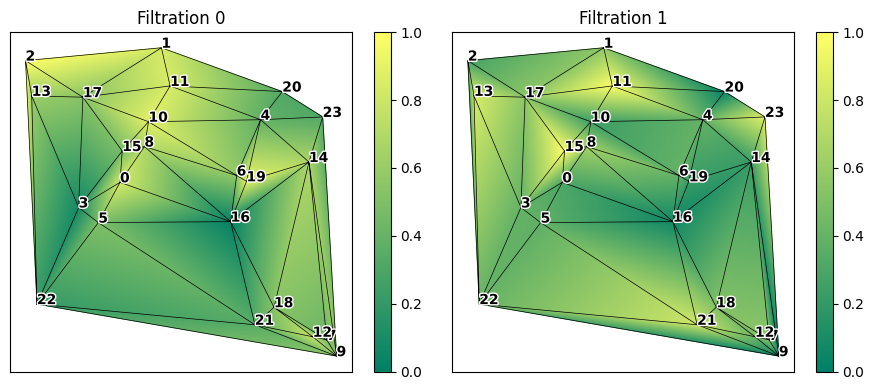

In [151]:
path = 'raports/pics/heights linear homotopy - complex with filtrations.png'

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

cmap = 'summer'
triang = tri.Triangulation(points[:, 0], points[:, 1], np.array(list(triangles)))
for i, heightsi in enumerate([heights0, heights1]):
    axs[i].set_title(f'Filtration {i}')
    sm = axs[i].tripcolor(triang, heightsi, shading='gouraud', cmap=cmap, vmin=0, vmax=1)
    axs[i].triplot(triang, color='black', linewidth=0.5)
    enumerate_points(points, ax=axs[i], weight='semibold', forewidth=2)
    plt.colorbar(sm, ax=axs[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.savefig(path)

/tmp/ipykernel_100289/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


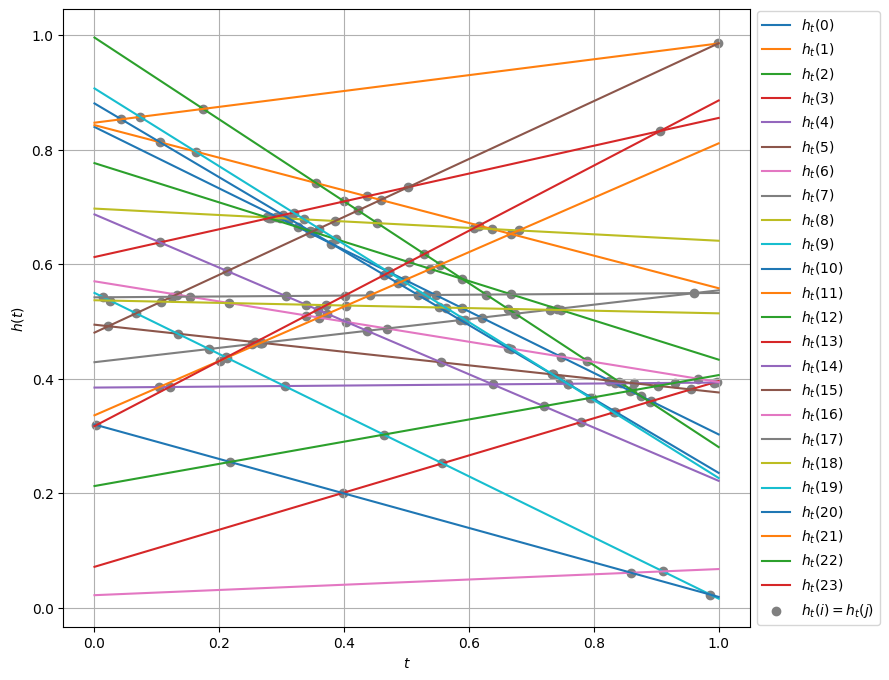

In [152]:
path = 'raports/pics/heights linear homotopy - heights homotopy.png'

fig, ax = plt.subplots(1, 1, figsize=(9, max(0.3*n, 4)))

#ax.set_title('Heights during the Homotopy')
for i, (h0, h1) in enumerate(zip(heights0, heights1)):
    ax.plot([0, 1], [h0, h1], label='$h_t({0})$'.format(i))

cross_x = get_cross_parameters(heights0, heights1)
cross_x[np.tril(np.ones(cross_x.shape, dtype=bool))] = np.nan
cross_y = heights0*(1 - cross_x) + heights1*cross_x
ax.scatter(cross_x, cross_y, color='grey', label='$h_t(i)=h_t(j)$')

ax.set_xlabel('$t$')
ax.set_ylabel('$h(t)$')
ax.grid(True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(path)

In [153]:
path_model_txt = 'texts/heights linear homotopy - model.tex'

with open(path_model_txt, 'r') as file:
    ltx_model = file.read()

replace_dict = {
    '{n}': str(n), 
    '{dim}': str(dim),
}

for key, value in replace_dict.items():
    ltx_model = ltx_model.replace(key, value)

print(ltx_model)

\section{Model}
\subsection{Complex, Filtration and Homotopy}
\par In this model we define the simplicial complex by the Delauney triangulation of $n = 24$ points uniformly distributed in $[0, 1]^d$ for $d = 2$.
\par We defining the filtration on this complex, by assuming uniformly distributed in $[0, 1]$ height $h(f)$ for each vertex $v$. Then the filtration value of the simplex will be the maximum haight of its vertices.
$$
    f(\sigma) = \max_{v\in \sigma} h(v)
$$
\par We define 2 filtrations like this and study the linear homotopy between them. In the Figure \ref{fig:complex} we can see these 2 filtrations:
\begin{figure}[h!]
    \centering
    \includegraphics[width=1.2\textwidth]{pics/heights linear homotopy - complex with filtrations.png}
    \caption{2 filtrations on the defined complex.}
    \label{fig:complex}
\end{figure}

\par Having these 2 filtrations we can define the homotopy between them by defining the linear homotopy between heights:
$$
    h_t(v) = h_0(v)\cdot(1 - 

### General Statistics

In [154]:
grouping_cols = ['order before', 'order after']
ignoring_cols = ['index in path', 'index in vetex transposition']
aggregation = {
    'path index': list, 
}

for key in df_transpositions_during_homotopy.columns[
    ~np.isin(df_transpositions_during_homotopy.columns, grouping_cols) &
    ~np.isin(df_transpositions_during_homotopy.columns, ignoring_cols) & 
    ~np.isin(df_transpositions_during_homotopy.columns, list(aggregation.keys()))
]:
    aggregation[key] = 'first'

df_unique_transpositions = df_transpositions_during_homotopy.groupby(grouping_cols).agg(aggregation).reset_index()

print(f'df_unique_transpositions.shape = {df_unique_transpositions.shape}')
df_unique_transpositions.head(2)


df_unique_transpositions.shape = (9245, 20)


,order before,order after,path index,Time,Value,Vertex 0,Vertex 1,Index 0,Index 1,Simplex 0,Simplex 1,stree before,stree after,transposition object,dim,type,switch,class,dp before,dp after
0,"((9,), (20,), (16,), (14,), (9, 14), (14, 16),...","((9,), (20,), (16,), (14,), (9, 14), (14, 16),...","[0, 1]",0.992339,0.393122,3,4,21,22,"(0, 3, 5)","(4,)",<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(0, 3, 5), (4,)>",<NA>,birth-death,no switch,no switch,<src.depth.DepthPoset object at 0x79036ea6f590>,<src.depth.DepthPoset object at 0x79036e98c650>
1,"((9,), (20,), (16,), (14,), (9, 14), (14, 16),...","((9,), (20,), (16,), (14,), (9, 14), (14, 16),...",[1],0.992339,0.393122,3,4,22,23,"(0, 3, 5)","(4, 10)",<gudhi.simplex_tree.SimplexTree object at 0x79...,<gudhi.simplex_tree.SimplexTree object at 0x79...,"<(0, 3, 5), (4, 10)>",<NA>,death-death,no switch,no switch,<src.depth.DepthPoset object at 0x790350f39c40>,<src.depth.DepthPoset object at 0x790350e1ed50>


In [155]:
df_stats = df_unique_transpositions[['dim', 'class']].value_counts(dropna=False).reset_index()
df_stats['dim'] = df_stats['dim'].astype(object).fillna('undefined')
df_stats = df_stats.pivot_table(index='class', columns='dim', values='count').fillna(0).astype(int)
df_stats.index.name = None
df_stats

dim,0,1,2,undefined
birth-birth,7,21,0,0
birth-death,0,48,0,0
death-death,0,14,23,0
no switch,267,2483,1031,5351


In [156]:
n_path0 = int(df_unique_transpositions['path index'].apply(tuple).value_counts()[(0,)])
n_path1 = int(df_unique_transpositions['path index'].apply(tuple).value_counts()[(1,)])
n_path01 = int(df_unique_transpositions['path index'].apply(tuple).value_counts()[(0, 1)])
n_path0, n_path1, n_path01

(4504, 4504, 237)

In [157]:
df_path_classes = df_transpositions_during_homotopy.copy()
df_path_classes['Vertices'] = df_path_classes.apply(lambda row: f'$\\langle{row['Vertex 0']}, {row['Vertex 1']}\\rangle$', axis=1)
df_path_classes['Figure'] = df_path_classes.apply(lambda row: f'\\ref{{fig:transposition{row['Vertex 0']}and{row['Vertex 1']}}}', axis=1)

df_path_classes = df_path_classes[['Figure', 'path index', 'Time', 'Value', 'Vertices', 'dim', 'class']].value_counts(dropna=False).reset_index()
df_path_classes['dim'] = df_path_classes['dim'].astype(object).fillna('undefined')
df_path_classes['Time'] = df_path_classes['Time'].apply(lambda s: f'{s:.3f}')
df_path_classes['Value'] = df_path_classes['Value'].apply(lambda s: f'{s:.3f}')


df_path_classes = df_path_classes.pivot_table(index=['Time', 'Vertices', 'Value', 'Figure', 'path index'], columns=['class', 'dim'], values='count').fillna(0).astype(int)

df_path_classes[('no switch', '')] = df_path_classes['no switch'].sum(axis=1)

df_path_classes = df_path_classes.drop(columns=df_path_classes.columns[np.vectorize(lambda x: (x[0] == 'no switch') & (x[1] != ''))(df_path_classes.columns)])
df_path_classes.columns = df_path_classes.columns.rename(['Type', 'Dim'])

# Переименуем уровень
new_index = df_path_classes.index.rename(['Time', 'Vertices', 'Value', 'Figure', 'Path'])

# Заменим значения в уровне 'path'
new_path_level = new_index.get_level_values('Path').map({0: 'Up', 1: 'Down'})

# Соберём новый MultiIndex
df_path_classes.index = pd.MultiIndex.from_arrays(
    [new_index.get_level_values(level) if level != 'Path' else new_path_level
     for level in new_index.names],
    names=new_index.names
)

print(f'df_path_classes.shape = {df_path_classes.shape}')
df_path_classes.head()

df_path_classes.shape = (288, 6)


Type                                                                   birth-birth  \
Dim                                                                              0   
Time  Vertices               Value Figure                         Path               
0.003 $\langle20, 23\rangle$ 0.319 \ref{fig:transposition20and23} Up             1   
                                                                  Down           1   
0.014 $\langle9, 17\rangle$  0.542 \ref{fig:transposition9and17}  Up             0   
                                                                  Down           0   
0.022 $\langle5, 15\rangle$  0.492 \ref{fig:transposition5and15}  Up             0   

Type                                                                       \
Dim                                                                     1   
Time  Vertices               Value Figure                         Path      
0.003 $\langle20, 23\rangle$ 0.319 \ref{fig:transposition20and23} Up    0   
                                                                  Down  0   
0.014 $\langle9, 17\rangle$  0.542 \ref{fig:transposition9and17}  Up    0   
                                                                  Down  0   
0.022 $\langle5, 15\rangle$  0.492 \ref{fig:transposition5and15}  Up    0   

Type                                                                   birth-death  \
Dim                                                                              1   
Time  Vertices               Value Figure                         Path               
0.003 $\langle20, 23\rangle$ 0.319 \ref{fig:transposition20and23} Up             0   
                                                                  Down           0   
0.014 $\langle9, 17\rangle$  0.542 \ref{fig:transposition9and17}  Up             0   
                                                                  Down           0   
0.022 $\langle5, 15\rangle$  0.492 \ref{fig:transposition5and15}  Up             0   

Type                                                                   death-death  \
Dim                                                                              1   
Time  Vertices               Value Figure                         Path               
0.003 $\langle20, 23\rangle$ 0.319 \ref{fig:transposition20and23} Up             0   
                                                                  Down           0   
0.014 $\langle9, 17\rangle$  0.542 \ref{fig:transposition9and17}  Up             0   
                                                                  Down           0   
0.022 $\langle5, 15\rangle$  0.492 \ref{fig:transposition5and15}  Up             0   

Type                                                                       \
Dim                                                                     2   
Time  Vertices               Value Figure                         Path      
0.003 $\langle20, 23\rangle$ 0.319 \ref{fig:transposition20and23} Up    0   
                                                                  Down  0   
0.014 $\langle9, 17\rangle$  0.542 \ref{fig:transposition9and17}  Up    0   
                                                                  Down  0   
0.022 $\langle5, 15\rangle$  0.492 \ref{fig:transposition5and15}  Up    0   

Type                                                                   no switch  
Dim                                                                               
Time  Vertices               Value Figure                         Path            
0.003 $\langle20, 23\rangle$ 0.319 \ref{fig:transposition20and23} Up           0  
                                                                  Down         0  
0.014 $\langle9, 17\rangle$  0.542 \ref{fig:transposition9and17}  Up          24  
                                                                  Down        24  
0.022 $\langle5, 15\rangle$  0.492 \ref{fig:transposition5and15}  Up          16

In [158]:
first_rows = 20
rows_on_page = 36

ltx_path_classes = [df_path_classes[:first_rows].to_latex()]
for i in range(first_rows, len(df_path_classes), rows_on_page):
    ltx_path_classes.append(df_path_classes[i:i + rows_on_page].to_latex())
ltx_path_classes = '\n'.join(ltx_path_classes)

In [159]:
ltx_stats = f"""
\\section{{General Statistics}}
\\par In 2 paths generated {len(df_unique_transpositions)} unique transpositions: {n_path0} in only upper path, {n_path1} in only down path and {n_path01} in both paths.
\\par The distribution of the switch transposition types and dimensions is given in the table:
\\begin{{center}}
{df_stats.to_latex()}
\end{{center}}

\\par And we can see more detailed table about how many simplex transpositions of each type lies in each reordering defined by the transposition of heights on vertices:
\\begin{{center}}
{ltx_path_classes}
\end{{center}}

""".strip()

<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_100289/2346763928.py:14: SyntaxWarning: invalid escape sequence '\e'
  """.strip()
/tmp/ipykernel_100289/2346763928.py:14: SyntaxWarning: invalid escape sequence '\e'
  """.strip()


In [160]:
#print(ltx_stats)

### Heights Transposition Reordering Schemes (Graphs)

In [161]:
path_template = 'raports/pics/heights linear homotopy - transpositions {0}-{1}.png'
paths_transp = []

cmap = pastelize_cmap()

n_plot_transpositions = 16

vertex_pairs = df_transpositions_during_homotopy.copy()
vertex_pairs = vertex_pairs[['Vertex 0', 'Vertex 1', 'switch', 'Time']]
vertex_pairs['switch'] = vertex_pairs['switch'].apply(lambda s: s in ['switch forward', 'switch backward'])
vertex_pairs = vertex_pairs.groupby(['Vertex 0', 'Vertex 1'])[['Time', 'switch']].mean().reset_index()
vertex_pairs = vertex_pairs.sort_values('switch', ascending=False)[:n_plot_transpositions].sort_values('Time')
vertex_pairs = vertex_pairs[['Vertex 0', 'Vertex 1']].values


for vertex0, vertex1 in tqdm(vertex_pairs, total=len(vertex_pairs)):
    path = path_template.format(vertex0, vertex1)

    dfi_edges = df_transpositions_during_homotopy.copy()
    dfi_edges = dfi_edges[(dfi_edges['Vertex 0'] == vertex0)&(dfi_edges['Vertex 1'] == vertex1)]
    time = dfi_edges['Time'].values[0]
    dfi_edges = dfi_edges[['order before', 'order after', 'class', 'dp before', 'dp after']]
    dfi_nodes = pd.concat([dfi_edges[['order before', 'dp before']].rename(columns=lambda s: s.replace(' before', '')), 
                           dfi_edges[['order after', 'dp after']].rename(columns=lambda s: s.replace(' after', ''))])
    dfi_nodes = dfi_nodes.reset_index(drop=True)
    dfi_nodes = dfi_nodes.loc[dfi_nodes['order'].drop_duplicates().index]
    dfi_nodes.sort_values('order').reset_index(drop=True)
    
    dfi_nodes = dfi_nodes.set_index('order')
    dfi_edges = dfi_edges.set_index(['order before', 'order after'])

    dfi_nodes['dp type'] = dfi_nodes['dp'].apply(lambda i: dp_types.index(i))
    dfi_nodes['color'] = dfi_nodes['dp type'].replace(dp_type_colors)
    dfi_nodes['label'] = dfi_nodes['dp type'].apply(lambda i: f'$DP_{{{i}}}$')

    dfi_edges['color'] = dfi_edges['class'].replace(transposition_type_colors)

    gi = nx.DiGraph()
    gi.add_nodes_from(dfi_nodes.index.values)
    gi.add_edges_from(dfi_edges.index.values)

    posi = nx.nx_agraph.graphviz_layout(gi, prog="dot", args='-Grankdir=LR')
    node_colors = dfi_nodes['color']
    node_labels = dfi_nodes['label']

    edge_colors = dfi_edges['color'][list(gi.edges)]


    title = f'Transposition of Vertices $\\langle{vertex0}, {vertex1}\\rangle$ at the Moment of Time={time:.3f}'

    fig, ax = plt.subplots(figsize=(9, 3))
    ax.set_title(title)

    #nx.draw_networkx(gi, pos=posi, node_color=node_colors, labels=node_labels, edge_color=edge_colors, width=2,
    #                 with_labels=True, ax=ax)
    
    if (len(gi.nodes) < 50) and (dfi_edges['class'].nunique() > 1):
        zorders = [1, 3, 2]
    else:
        zorders = [1, 2, 3]
    ploted_nodes = nx.draw_networkx_nodes(gi, posi, node_size=600, node_color=node_colors, ax=ax)
    ploted_edges = nx.draw_networkx_edges(gi, posi, width=2, node_size=600, edge_color=edge_colors, ax=ax)
    ploted_labels = nx.draw_networkx_labels(gi, posi, font_size=14, labels=node_labels, ax=ax)
    ploted_nodes.set_zorder(zorders[0])
    for edge in ploted_edges:
        edge.set_zorder(zorders[1])  
    for text in ploted_labels.values():
        text.set_zorder(zorders[2])


    legend_arrows = [
        FancyArrow(0, 0, 1.2, 0, 
                   width=0.01, 
                   head_width=0.03, 
                   head_length=0.1, 
                   color=transpsoition_class_colors[label], 
                   label=label) for label in np.sort(pd.unique(dfi_edges['class']))
    ]
    has_cycle = len(nx.cycle_basis(gi.to_undirected())) > 0
    if has_cycle:
        ax.legend(handles=legend_arrows, loc='center')
    else:
        ax.legend(handles=legend_arrows, loc='upper right')

    #plt.show()
    plt.savefig(path)
    plt.close()
    paths_transp.append((vertex0, vertex1, path.replace('raports/', '')))

  0%|          | 0/16 [00:00<?, ?it/s]

In [162]:
ltx_transp_template = r"""
%\subsection{Reordering by transposition of vertices V0 and V1}
\begin{figure}[htbp]
    \centering
    \includegraphics[width=1.2\textwidth]{PATH}
    \caption{Reordering by transposition of vertices V0 and V1}
    \label{fig:transpositionV0andV1}
\end{figure}
""".strip()

ltx_transps = f"""
\\section{{present the details}}
\\par Here we detalize the paths, how depth poset changed during the homotopy by different paths.
\\par In the figures we can see graphs, which edges coresponds the transpositions of simplices, and nodes are orders, coresponding one of {len(dp_types)} Depth Posets we got.
{'\n'.join([ltx_transp_template.replace('V0', str(v0)).replace('V1', str(v1)).replace('PATH', path) for v0, v1, path in paths_transp])}
"""

### Depth Poset Types

In [163]:
dp_type_first = dp_types.index(df_transpositions_during_homotopy.iloc[0]['dp before'])
dp_type_last = dp_types.index(df_transpositions_during_homotopy.iloc[-1]['dp after'])
dp_type_first, dp_type_last

(0, 161)

In [178]:
n_dp_types_to_plot = 12

dps_to_plot_df = df_transpositions_during_homotopy[df_transpositions_during_homotopy.apply(lambda row: (row[['Vertex 0', 'Vertex 1']].values == vertex_pairs).all(axis=1).any(), axis=1)]
dps_to_plot_df = pd.concat([dps_to_plot_df['dp before'], dps_to_plot_df['dp after']])
dps_to_plot = []
for dp in tqdm(dps_to_plot_df, total=len(dps_to_plot_df), desc='Got DPs to plot'):
    if not dp in dps_to_plot:
        dps_to_plot.append(dp)
dps_to_plot_index = np.array([dp_types.index(dp) for dp in dps_to_plot])
dps_to_plot_index = np.unique(dps_to_plot_index)
dps_to_plot_index = dps_to_plot_index[(dps_to_plot_index != dp_type_first)&(dps_to_plot_index != dp_type_last)]
dps_to_plot_index = np.random.choice(dps_to_plot_index, n_dp_types_to_plot - 2, replace=False)
dps_to_plot_index = np.concatenate([[dp_type_first, dp_type_last], dps_to_plot_index])
dps_to_plot_index

Got DPs to plot:   0%|          | 0/732 [00:00<?, ?it/s]

array([  0, 161,  96,  95, 171,  25, 169,  35, 239, 114, 143, 216])

In [179]:
path_template = 'raports/pics/heights linear homotopy - dp{0}.png'
paths_dp_types = []

for i in tqdm(dps_to_plot_index, total=n_dp_types_to_plot):
    dp = dp_types[i]
    path = path_template.format(i)
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.set_title(f'Depth Poset $DP_{{{i}}}$')

    gi = dp.get_transitive_reduction()
    #posi = nx.nx_agraph.graphviz_layout(gi, prog="dot", args='-Grankdir=DU')
    posi = dp.hasse_layout(alignment_slope=0.1)
    
    #node_colors = ['cyan' if len(node.source[0]) == 1 else 'gold' for node in gi.nodes]
    node_color = dp_type_colors[i]

    nx.draw_networkx(gi, pos=posi, node_color=node_color, node_size=600, ax=ax)
    plt.savefig(path)
    plt.close()
    paths_dp_types.append(path.replace('raports/', ''))

  0%|          | 0/12 [00:00<?, ?it/s]

In [185]:
ltx_dp_template = r"""
\begin{figure}[h]
    \centering
    \includegraphics[width=1.2\textwidth]{PATH}
    \caption{Depth Poset $DP_{INDEX}$}
    \label{fig:dpINDEX}
\end{figure}
""".strip()

ltx_dps = f"""
\\section{{Depth Posets}}
\\par During the transposition we got {len(dp_types)} depth posets. In this section we listed few of them. 
\\par The depth poset coresponding the first filtration we can see in Figure \\ref{{fig:dp{dp_type_first}}}, 
and the depth poset coresponding the last filtration we can see in Figure \\ref{{fig:dp{dp_type_last}}}.

{'\n'.join([ltx_dp_template.replace('PATH', path).replace('INDEX', str(i)) for i, path in zip(dps_to_plot_index, paths_dp_types)])}
"""

### Generate the final text

In [186]:
ltx_body = f"""
\\tableofcontents
\\newpage

{ltx_model}
\\newpage

{ltx_stats}
\\newpage 

{ltx_transps}
\\newpage

{ltx_dps}
"""

In [187]:
path_template = 'texts/template.tex'

with open(path_template, 'r') as file:
    ltx_report = file.read()

ltx_report = ltx_report.replace('BODY', ltx_body)

#print(ltx_report)

In [188]:
output_path = 'raports/heights linear homotopy.tex'
with open(output_path, 'w') as file:
    file.write(ltx_report)

In [189]:
%cd raports
os.system('pdflatex heights\ linear\ homotopy.tex')
os.system('pdflatex heights\ linear\ homotopy.tex')
%cd ..

<>:2: SyntaxWarning: invalid escape sequence '\ '
<>:3: SyntaxWarning: invalid escape sequence '\ '
<>:2: SyntaxWarning: invalid escape sequence '\ '
<>:3: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_100289/3666401241.py:2: SyntaxWarning: invalid escape sequence '\ '
  os.system('pdflatex heights\ linear\ homotopy.tex')
/tmp/ipykernel_100289/3666401241.py:3: SyntaxWarning: invalid escape sequence '\ '
  os.system('pdflatex heights\ linear\ homotopy.tex')
/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/feodor/Jupyter/depth-poset/raports
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./heights linear homotopy.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/amsfonts/amsfonts.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/hyperref/hyperref.sty
(/usr/share/texlive/texmf-